In [ ]:
import os
os.environ['CUDA_DEVICE_ORDER']='PCI_BUS_ID'
os.environ['CUDA_VISIBLE_DEVICES']='0'

In [ ]:
import torch
import numpy as np
from torch.utils import data
import torch.nn as nn
import torch.nn.functional as F
import math
import parser

import wave
from IPython.display import Audio
import io

import torchaudio
import librosa
import soundfile as sf
from torch.optim import *
from torch.optim.lr_scheduler import *
from torch.autograd import Variable
from Convexity_check_Net_mModal import Net, NewNet, TransformerEncoder, Transformer, MMTEncoder, LateFusion
# from util_in_origin import *
from util_in_multi_h5_unnorm import *
from AudioResNet import resnet50

import gc
import time

In [ ]:
from util_out import *
from util_f1 import *
from scipy.io import loadmat, savemat
import argparse

In [ ]:
torch.cuda.is_available()
torch.cuda.device_count()
# torch.cuda.set_device(0)

# VICTIM MODEL

In [5]:
# Parse input arguments
def mybool(s):
    return s.lower() in ['t', 'true', 'y', 'yes', '1']
parser = argparse.ArgumentParser()
parser.add_argument('--model_type', type = str, default = None, required=True)
parser.add_argument('--TALNet', action = 'store_true')              # specify this to evaluate the pre-trained TALNet model
parser.add_argument('--embedding_size', type = int, default = 1024) # this is the embedding size after a pooling layer
                                                                    # after a non-pooling layer, the embeddings size will be twice this much
parser.add_argument('--n_conv_layers', type = int, default = 10)
parser.add_argument('--n_trans_layers', type = int, default = 1)
parser.add_argument('--kernel_size', type = str, default = '3x3')     # 'n' or 'nxm'
parser.add_argument('--n_pool_layers', type = int, default = 5)     # the pooling layers will be inserted uniformly into the conv layers
                                                                    # the should be at least 2 and at most 6 pooling layers
                                                                    # the first two pooling layers will have stride (2,2); later ones will have stride (1,2)
parser.add_argument('--batch_norm', type = mybool, default = True)
parser.add_argument('--dropout', type = float, default = 0.0)
parser.add_argument('--pooling', type = str, default = 'lin', choices = ['max', 'ave', 'lin', 'exp', 'att'])
parser.add_argument('--batch_size', type = int, default = 250)
parser.add_argument('--ckpt_size', type = int, default = 1000)      # how many batches per checkpoint
parser.add_argument('--optimizer', type = str, default = 'adam', choices = ['adam', 'sgd'])
parser.add_argument('--init_lr', type = float, default = 1e-3)
parser.add_argument('--weight_decay', type = float, default = 0)
parser.add_argument('--beta1', type = float, default = 0.9)
parser.add_argument('--beta2', type = float, default = 0.999)
parser.add_argument('--lr_patience', type = int, default = 3)
parser.add_argument('--lr_factor', type = float, default = 0.8)
parser.add_argument('--random_seed', type = int, default = 15213)
parser.add_argument('--ckpt', type = int)
parser.add_argument('--additional_outname', type = str, default = '')
parser.add_argument('--addpos', type = mybool, default = False)
parser.add_argument('--transformer_dropout', type = float, default = 0.5)
parser.add_argument('--gradient_accumulation', type = int, default = 1)
parser.add_argument('--scheduler', type = str, default = 'reduce', choices = ['reduce', 'warmup-decay'])

###MODEL INPUT PARAMS###
# args = parser.parse_args(args=['--model_type=TAL-trans','--init_lr=4e-4','--embedding_size=1024','--pooling=att','--n_trans_layers=2', '--batch_size=100', '--ckpt_size=2500', '--n_conv_layers=10', '--n_pool_layers=5', '--ckpt=18'
# ])



_StoreAction(option_strings=['--scheduler'], dest='scheduler', nargs=None, const=None, default='reduce', type=<class 'str'>, choices=['reduce', 'warmup-decay'], help=None, metavar=None)

In [6]:
python train_multimodal_late_fusion.py --model_type AST --embedding_size 1024 --batch_size 100 --ckpt_size 2500 --init_lr 4e-4 --pooling att --max_ckpt 30 --n_trans_layers 2 --gradient_accumulation 3 --transformer_dropout 0.75 --additional_outname dadada --scheduler warmup-decay 
MMTLF-embed1024-10C5P-kernel3x3-bn-drop0.0-att-batch100-ckpt2500-adam-lr4e-04-pat3-fac0.8-seed15213-Trans2-weight-decay0.00000000-betas0.900-0.999late_fusion_all_additional_linear

In [8]:
args = parser.parse_args(args=['--model_type=MMTLF','--init_lr=4e-4','--embedding_size=1024','--pooling=att','--n_trans_layers=1', '--batch_size=100', '--ckpt_size=2500', '--n_conv_layers=10', '--n_pool_layers=5', '--ckpt=19', '--additional_outname=late_fusion_all_additional_linear'])

In [8]:
args = parser.parse_args(args=['--model_type=TAL-new','--init_lr=4e-4','--embedding_size=1024','--pooling=att','--n_trans_layers=2', '--batch_size=100', '--ckpt_size=2500', '--n_conv_layers=10', '--n_pool_layers=5', '--ckpt=19', '--additional_outname='])

#Ablation Test

In [9]:
args = parser.parse_args(args=['--model_type=TAL-trans','--init_lr=4e-4','--embedding_size=1024','--pooling=att','--n_trans_layers=2', '--batch_size=100', '--ckpt_size=2500', '--n_conv_layers=10', '--n_pool_layers=5', '--ckpt=19', '--additional_outname=sixteenhead_py3'
])

In [10]:
args = parser.parse_args(args=['--model_type=TAL-trans','--init_lr=4e-4','--embedding_size=1024','--pooling=att','--n_trans_layers=2', '--batch_size=100', '--ckpt_size=2500', '--n_conv_layers=10', '--n_pool_layers=5', '--ckpt=18', '--additional_outname=nores_py3'
])

In [11]:
args = parser.parse_args(args=['--model_type=TAL-trans','--init_lr=4e-4','--embedding_size=1024','--pooling=att','--n_trans_layers=2', '--batch_size=100', '--ckpt_size=2500', '--n_conv_layers=10', '--n_pool_layers=5', '--ckpt=18','--additional_outname='
])

In [9]:
if 'x' not in args.kernel_size:
    args.kernel_size = args.kernel_size + 'x' + args.kernel_size

In [10]:
# Locate model file and prepare directories for prediction and evaluation
expid = '%s-embed%d-%dC%dP-kernel%s-%s-drop%.1f-%s-batch%d-ckpt%d-%s-lr%.0e-pat%d-fac%.1f-seed%d-Trans%d-weight-decay%.8f-betas%.3f-%.3f' % (
    args.model_type,
    args.embedding_size,
    args.n_conv_layers,
    args.n_pool_layers,
    args.kernel_size,
    'bn' if args.batch_norm else 'nobn',
    args.dropout,
    args.pooling,
    args.batch_size,
    args.ckpt_size,
    args.optimizer,
    args.init_lr,
    args.lr_patience,
    args.lr_factor,
    args.random_seed,
    args.n_trans_layers,
    args.weight_decay,
    args.beta1, 
    args.beta2
)

In [11]:
expid += args.additional_outname
WORKSPACE = os.path.join('~/data_folder/TAL-kaixin_best_model/', expid)
PRED_PATH = os.path.join(WORKSPACE, 'pred')
if not os.path.exists(PRED_PATH): os.makedirs(PRED_PATH)
EVAL_PATH = os.path.join(WORKSPACE, 'eval')
if not os.path.exists(EVAL_PATH): os.makedirs(EVAL_PATH)
if args.TALNet:
    WORKSPACE = '../../workspace/audioset/embed1024-10C5P-kernel3x3-bn-drop0.0-lin-batch250-ckpt1000-adam-lr1e-03-pat3-fac0.8-seed15213'
    PRED_PATH = os.path.join(WORKSPACE, 'pred')
    EVAL_PATH = os.path.join(WORKSPACE, 'eval')
    MODEL_FILE = os.path.join(WORKSPACE, 'model', 'checkpoint15.pt')
    PRED_FILE = os.path.join(PRED_PATH, 'checkpoint15.mat')
    EVAL_FILE = os.path.join(EVAL_PATH, 'checkpoint15.txt')
elif args.model_type == 'MMTLF':
    WORKSPACE = '../../workspace/audioset/MMTLF-embed1024-10C5P-kernel3x3-bn-drop0.0-att-batch100-ckpt2500-adam-lr4e-04-pat3-fac0.8-seed15213-Trans2-weight-decay0.00000000-betas0.900-0.999late_fusion_all_additional_linear/'
    MODEL_FILE = os.path.join(WORKSPACE, 'model', 'checkpoint5.pt')
else:
    MODEL_FILE = os.path.join(WORKSPACE, 'model', 'checkpoint%d.pt' % args.ckpt)
    PRED_FILE = os.path.join(PRED_PATH, 'checkpoint%d.mat' % args.ckpt)
    EVAL_FILE = os.path.join(EVAL_PATH, 'checkpoint%d.txt' % args.ckpt)

In [12]:
args

Namespace(TALNet=False, additional_outname='late_fusion_all_additional_linear', addpos=False, batch_norm=True, batch_size=100, beta1=0.9, beta2=0.999, ckpt=19, ckpt_size=2500, dropout=0.0, embedding_size=1024, gradient_accumulation=1, init_lr=0.0004, kernel_size='3x3', lr_factor=0.8, lr_patience=3, model_type='MMTLF', n_conv_layers=10, n_pool_layers=5, n_trans_layers=1, optimizer='adam', pooling='att', random_seed=15213, scheduler='reduce', transformer_dropout=0.5, weight_decay=0)

In [13]:
MODEL_FILE

'../../workspace/audioset/MMTLF-embed1024-10C5P-kernel3x3-bn-drop0.0-att-batch100-ckpt2500-adam-lr4e-04-pat3-fac0.8-seed15213-Trans2-weight-decay0.00000000-betas0.900-0.999late_fusion_all_additional_linear/model/checkpoint5.pt'

In [14]:
# Load model
args.kernel_size = tuple(int(x) for x in args.kernel_size.split('x'))
#model = Net(args).cuda()
if args.model_type == 'TAL':
    print('debug')
    model = Net(args).cuda()
elif args.model_type == 'TAL-trans':
    model = TransformerEncoder(args).cuda()
elif args.model_type == 'TAL-new':
    model = NewNet(args).cuda()
elif args.model_type == 'Trans':
    model = Transformer(args).cuda()
elif args.model_type == 'resnet':
    model = resnet50().cuda()
elif args.model_type == 'MMT':
    model = MMTEncoder(0, args).cuda()
elif args.model_type == 'MMTLF':
    model = LateFusion(args).cuda()
else:
    print ('model type not recognized')
    exit(0)
model.load_state_dict(torch.load(MODEL_FILE)['model'])
#model.eval()

/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/Convexity_check_Net_mModal.py:858: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc_prob.weight); nn.init.constant(self.fc_prob.bias, 0)
/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/Convexity_check_Net_mModal.py:858: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.xavier_uniform(self.fc_prob.weight); nn.init.constant(self.fc_prob.bias, 0)
/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/Convexity_check_Net_mModal.py:860: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  nn.init.xavier_uniform(self.fc_att.weight); nn.init.constant(self.fc_att.bias, 0)
/ocean/projects/iri120008p/billyli/DayLongAudio/audioset_py3/Convexity_check_Net_mModal.py:860: UserWarning: nn.init.constant is now deprecated in favor of nn.init.constant_.
  nn.init.xavier_uni

<All keys matched successfully>

In [15]:
model.eval()

LateFusion(
  (alpha): Linear(in_features=1024, out_features=1024, bias=True)
  (beta): Linear(in_features=1024, out_features=1024, bias=True)
  (fc_prob): Linear(in_features=1024, out_features=527, bias=True)
  (fc_att): Linear(in_features=1024, out_features=527, bias=True)
  (branch1): TransformerEncoder(
    (conv1): ConvBlock(
      (conv): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv2): ConvBlock(
      (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv3): ConvBlock(
      (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (bn): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (conv4): ConvBlock(
      (conv): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1)

# data pipeline

# data pipeline

In [16]:
import h5py
import numpy as np
hf = h5py.File('../../data/googleAudioSet/data.h5', 'r')
# hf = h5py.File('/local/11774768/data.h5', 'r')
feat_as = hf['eval']['data']['feat_a']
feat_vs = hf['eval']['data']['feat_v']
labels = hf['eval']['data']['labels']

In [17]:
gas_eval_global_prob = model.predict(feat_as[:] ,feat_vs[:] , verbose=False)

In [18]:
bottleneck_feature = gas_eval_global_prob[1]

In [19]:
labels = np.array(labels)

In [20]:
def obtain_samples(bottleneck_features, labels, class_name):
    return bottleneck_feature[np.where(labels[:,class_name])]

In [21]:
import itertools
def sampling_inner_points(points, max_count = None):
    total_samples = len(points)
    new_samples = []
    for count, combination in enumerate(itertools.permutations(range(total_samples),2)):
        if max_count:
            if max_count <= count:
                break
        a,b = combination
        rand = np.random.uniform(low=0.0, high=1.0, size=None)
        sample = rand * points[a] + (1 - rand) * points[b]
        new_samples.append(sample)
    return np.array(new_samples)

In [22]:
test_class = 0
test = sampling_inner_points(obtain_samples(bottleneck_feature,labels,test_class),10000)

In [23]:
test_result = model.middlePredict(test, verbose=False)[0]

In [24]:
correct_count = 0
for item in test_result[:,test_class]:
    if item >=0.1:
        correct_count += 1
correct_count

9954

In [25]:
test.shape

(10000, 10, 1024)

In [26]:
import csv
reader = csv.reader(open('./index_count.csv', 'r'))
index_count = {}
for row in reader:
    key, v = row
    try:
        index_count[int(key)] = int(v)
    except:
        print(key)
        index_count[137] = int(v)

﻿137


In [28]:
to_plot = []
for test_class in range(527):
    test = sampling_inner_points(obtain_samples(bottleneck_feature,labels,test_class),2000)
    test_result = model.middlePredict(test, verbose=False)[0]
    correct_count = 0
#     for item in test_result:
#         print(np.max(item))
    for item in test_result[:,test_class]:
        if item >=0.1:
            correct_count += 1
    print(test_class, correct_count, len(test), index_count[test_class])
    to_plot.append([test_class, correct_count, len(test), index_count[test_class]])

0 1988 2000 1005156
1 294 2000 17653
2 209 2000 8438
3 778 2000 11605
4 245 2000 2204
5 3 2000 15530
6 588 2000 802
7 41 2000 1653
8 0 2000 1308
9 0 2000 451
10 0 2000 1829
11 0 2000 734
12 691 2000 387
13 64 2000 613
14 342 2000 1185
15 585 2000 1594
16 1034 2000 5577
17 355 2000 802
18 30 2000 931
19 330 2000 1796
20 41 2000 782
21 17 2000 1631
22 506 2000 1400
23 738 2000 2330
24 24 2000 1195
25 0 2000 155
26 124 2000 261
27 899 2000 42131
28 508 2000 6611
29 310 2000 430
30 115 2000 1654
31 588 2000 4844
32 48 2000 7163
33 349 2000 7889
34 363 2000 2584
35 256 2000 590
36 627 2000 4434
37 198 2000 369
38 8 2000 642
39 45 2000 274
40 394 2000 1925
41 80 2000 773
42 24 2000 126
43 1386 2000 2274
44 0 2000 269
45 32 2000 232
46 39 2000 451
47 152 2000 811
48 0 2000 295
49 708 2000 1141
50 8 2000 145
51 1129 2000 4349
52 1220 2000 510
53 764 2000 1623
54 648 2000 769
55 13 2000 303
56 626 2000 77
57 192 2000 193
58 796 2000 1242
59 480 2000 871
60 975 2000 1170
61 373 2000 377
62 305 2

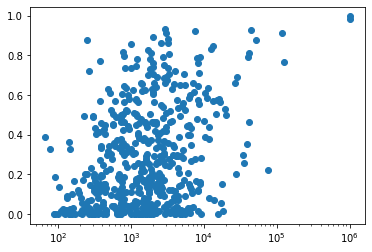

In [33]:
import matplotlib.pyplot as plt
plt.scatter(np.array(to_plot)[:,3], np.array(to_plot)[:,1]/np.array(to_plot)[:,2])
plt.xscale('log')

In [38]:
from  scipy.stats import pearsonr
pearsonr(np.log(np.array(to_plot)[:,3]), np.array(to_plot)[:,1]/np.array(to_plot)[:,2])

(0.350703435749607, 1.0698908667595439e-16)

In [17]:
# gas_eval_global_prob, gas_eval_global_feat = model.predict(feat_as, feat_vs, verbose=False)
# feat_as = hf['valid']['data']['feat_a']
# feat_vs = hf['valid']['data']['feat_v']
# labels = hf['valid']['data']['labels']
# gas_valid_global_prob, gas_valid_global_feat = model.predict(feat_as, feat_vs, verbose=False)

In [54]:
gas_eval_global_prob = model.predict(feat_as[:] + perturbation_a,feat_vs[:] + perturbation_v, verbose=False)
# gas_eval_global_prob = model.predict(feat_as[:],feat_vs[:], verbose=False)

In [55]:
# hf_feat = h5py.File('latefusion_bottleneck_feat.h5', 'w')
# hf_feat.create_dataset('feat_eval', data=gas_eval_global_feat)
# hf_feat.create_dataset('feat_valid', data=gas_valid_global_feat)

In [56]:
# hf_feat.close()
# del gas_eval_global_feat
# del gas_valid_global_feat

In [57]:
gas_eval_global_prob[0].shape

(20098, 527)

In [58]:
gas_eval_global_prob = gas_eval_global_prob[0]

In [39]:
# Remember to normalize eval if we are to use normalized model

In [33]:
# %matplotlib inline
# import pickle
# import matplotlib.pyplot as plt
# temp = pickle.load(open('adversarial_temp/delta_global_eps_norm_2_eps_0_1_no_delta_force.pkl', 'rb'))
# # temp[0:200, :] =0
# plt.imshow(temp.T,interpolation='nearest', aspect='auto')
# plt.colorbar()

In [34]:
np.clip(temp,0,1)

NameError: name 'temp' is not defined

In [35]:
temp = feat_vs+perturbation
gas_eval_global_prob = model.predict(feat_as,  np.clip(temp, 0,23.27987289428711), verbose = False)

NameError: name 'perturbation' is not defined

In [36]:
temp = feat_as+perturbation
gas_eval_global_prob = model.predict(np.clip(temp, -2, 2),  feat_vs , verbose = False)

NameError: name 'perturbation' is not defined

In [37]:
temp1 = feat_as + perturbation_a
temp2 = feat_vs + perturbation_v

gas_eval_global_prob = model.predict(np.clip(temp1, -2, 2), np.clip(temp2, 0,23.27987289428711), verbose = False)

NameError: name 'perturbation_a' is not defined

In [38]:
gas_eval_global_prob = model.predict(feat_as[:],feat_vs[:] , verbose=False)[0]
print(gas_eval_global_prob.shape)

TypeError: predict() got multiple values for argument 'verbose'

In [26]:
import csv
class_name = []
with open('../meta/class_labels_indices.csv', newline='') as csvfile:
    spamreader = csv.reader(csvfile, delimiter=',', quotechar='|')
    for row_id, row in enumerate(spamreader):
        if row_id >= 1:
            class_name.append(row[2])

In [27]:
print('Performance on Google Audio Set:')
print("   CLASS ||    AP |   AUC |    d' | NAME")
FORMAT  = ' %00007s || %5.3f | %5.3f |%6.03f |%s '
SEP     = ''.join('+' if c == '|' else '-' for c in FORMAT)
print(SEP)

Performance on Google Audio Set:
   CLASS ||    AP |   AUC |    d' | NAME
---------++-------+-------+-------+---


In [59]:

# 0.427 | 0.971 | 2.686
# 0.37905724410180536 0.9626179342278633 2.519999363956429
gas_eval_y =labels
classwise = []
classwise_dict = []
N_CLASSES = gas_eval_global_prob.shape[-1]
for i in range(N_CLASSES):
    a, b, c = gas_eval(gas_eval_global_prob[:,i], gas_eval_y[:,i])     # AP, AUC, dprime
    classwise_dict.append({'mAP':a, 'AUC':b, 'dprime':c, 'id':i})
    classwise.append((a, b, c, i ))
map, mauc = numpy.array(classwise).mean(axis = 0)[:2]
print (map, mauc, dprime(mauc))
classwise.sort(key=lambda x: x[0])

print(FORMAT % ('Average', map, mauc, dprime(mauc), 'Name'))
print(SEP)
for c in classwise:
    print(c, class_name[c[3]])
# for i in range(N_CLASSES):
#     print(FORMAT % ((str(i),) + classwise[i]+ (class_name[i],)))


0.0332347265415679 0.7480406047621055 0.9451706064778378
 Average || 0.033 | 0.748 | 0.945 |Name 
---------++-------+-------+-------+---
(0.0020254744341979334, 0.329996337650057, -0.6221454669006927, 526) "Field recording"
(0.0020969556179691443, 0.3054108048627211, -0.7196947148200296, 366) "Chopping (food)"
(0.002253974956028461, 0.3656461057324417, -0.4856509922421068, 439) "Splinter"
(0.0023531479078620307, 0.4449501329292494, -0.1957701611369961, 436) "Boom"
(0.002517469581972276, 0.4328979106364574, -0.2390035665846017, 423) "Sanding"
(0.0025405666659380653, 0.4308293742456447, -0.24644514754674882, 413) "Air conditioning"
(0.0025614516522998944, 0.4506204426791485, -0.17549535241508638, 345) "Dental drill
(0.0025706747102641546, 0.45044747488160797, -0.1761132633666606, 451) "Gush"
(0.002594552276794084, 0.4320469152948361, -0.24206421816146592, 421) "Sawing"
(0.002610164579445439, 0.4444413946834348, -0.1975911166366155, 118) "Caw"
(0.002671681842275201, 0.4249129423225869, -0

# Adversarial Routine

In [19]:
import pickle
import numpy as np
temp = pickle.load(open('video_stats.pkl','rb'))

In [20]:
np.max(pickle.load(open('min_max_values.pkl','rb'))['max_frame_v'])

23.27987289428711

In [17]:
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(feat_as[:]), torch.from_numpy(feat_vs[:]), torch.from_numpy(labels[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=100, shuffle=True)

In [18]:
def pgd(model, dataloader, delta_global, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().eval()
    targeted = y_target is not None
    criterion = nn.BCELoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, feat_v, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            feat_v = feat_v.cuda()
            
            x_adv_1 = feat_a + delta_global #.to(x.device)
            x_adv_1 = x_adv_1.clamp(x_min, x_max)
            # only video
            x_adv_2 = feat_v 
            
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)
            N_2, T_2, V_2 = x_adv_2.shape
#             print(N_2,T_2,V_2)
            #######   data loaded ###################
            _x_adv_1 = x_adv_1.clone().detach().requires_grad_(True).cuda()
            _x_adv_2 = x_adv_2
            #######   get gradient #################
#             with torch.no_grad():
            out = model(_x_adv_1, _x_adv_2)
#             print(out[0].shape)
            loss = criterion(out[0], y.cuda())
            loss_global += loss.item()
#             print(f'loss:{loss}')
            loss.backward()
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients = _x_adv_1.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients = _x_adv_1.grad/_x_adv_1.grad.norm(step_norm, dim=-1).view(-1, T_1, 1)
                    gradients *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_1 -= gradients
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_1 += gradients
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_1 = torch.max(torch.min(x_adv_1, feat_a + eps), feat_a - eps)
                delta = x_adv_1 - feat_a
            else:
                delta = x_adv_1 - feat_a
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
            mask = delta.view(delta.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
            scaling_factor = delta.view(delta.shape[0], T_1, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor[mask] = eps
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, T_1, 1)
            delta = torch.mean(delta,0)
            delta_global += delta * N_1 / 20098
            
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
        print(f'global loss:{loss_global}')
    return delta_global

In [19]:
model.named_parameters()

<generator object Module.named_parameters at 0x7eeaa628aed0>

In [20]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), num_steps=20, step_size=0.1, step_norm='inf', eps= 0.1, eps_norm='inf', x_min=-2, x_max=2, y_target=None )


global loss:4.021172691136599
global loss:4.025673784315586
global loss:4.028322337195277
global loss:4.0347536616027355
global loss:4.044867502525449
global loss:4.060211228206754
global loss:4.084540078416467
global loss:4.118848284706473
global loss:4.149778325110674
global loss:4.182487282902002
global loss:4.225638434290886
global loss:4.279992105439305
global loss:4.352727081626654
global loss:4.440526958554983
global loss:4.55098138935864
global loss:4.682586831972003
global loss:4.847375093027949
global loss:5.036936214193702
global loss:5.250048691406846
global loss:5.4835350047796965


In [21]:
perturbation = perturb.detach().cpu()
perturbation_a_only = perturbation.numpy()

In [22]:
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(feat_as[:]), torch.from_numpy(feat_vs[:]), torch.from_numpy(labels[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=100, shuffle=True)

In [23]:
def pgd(model, dataloader, delta_global, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().eval()
    targeted = y_target is not None
    criterion = nn.BCELoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, feat_v, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            x_adv_1 = feat_a
            feat_v = feat_v.cuda()
            # only video
            x_adv_2 = feat_v + delta_global #.to(x.device)
            x_adv_2 = x_adv_2.clamp(x_min, x_max)
            
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)
            N_2, T_2, V_2 = x_adv_2.shape
#             print(N_2,T_2,V_2)
            #######   data loaded ###################
            _x_adv_1 = feat_a
            _x_adv_2 = x_adv_2.clone().detach().requires_grad_(True).cuda()
            #######   get gradient #################
#             with torch.no_grad():
            out = model(_x_adv_1, _x_adv_2)
#             print(out[0].shape)
            loss = criterion(out[0], y.cuda())
            loss_global += loss.item()
#             print(f'loss:{loss}')
            loss.backward()
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients = _x_adv_2.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients = _x_adv_2.grad/_x_adv_2.grad.norm(step_norm, dim=-1).view(-1, T_2, 1)
                    gradients *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_2 -= gradients
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_2 += gradients
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_2 = torch.max(torch.min(x_adv_2, feat_v + eps), feat_v - eps)
                delta = x_adv_2 - feat_v
            else:
                delta = x_adv_2 - feat_v
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
            mask = delta.view(delta.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
            scaling_factor = delta.view(delta.shape[0], T_2, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor[mask] = eps
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, T_2, 1)
            delta = torch.mean(delta,0)
            delta_global += delta * N_2 / 20098
            
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
        print(f'global loss:{loss_global}')
    return delta_global

In [24]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((10,2048)).cuda(), num_steps=20, step_size=0.1, step_norm='inf', eps= 0.1, eps_norm='inf', x_min=-0.51, x_max=1.51, y_target=None )






global loss:4.052812464535236
global loss:4.084545601159334
global loss:4.138830292969942
global loss:4.233388312160969
global loss:4.399552414193749
global loss:4.65200812369585
global loss:4.9532044641673565
global loss:5.246565429493785
global loss:5.495519766584039
global loss:5.700055651366711
global loss:5.8773121275007725
global loss:6.027423532679677
global loss:6.15042126365006
global loss:6.245867017656565
global loss:6.314192967489362
global loss:6.362946743145585
global loss:6.397345703095198
global loss:6.421141775324941
global loss:6.437668612226844
global loss:6.445729523897171


In [25]:
perturbation = perturb.detach().cpu()
perturbation_v_only = perturbation.numpy()

In [16]:
pgd_dataset = torch.utils.data.TensorDataset(torch.from_numpy(feat_as[:]), torch.from_numpy(feat_vs[:]), torch.from_numpy(labels[:].astype('float32')))
pgd_dataloader = torch.utils.data.DataLoader(pgd_dataset, batch_size=100, shuffle=True)

In [17]:
def pgd(model, dataloader, delta_global_a, delta_global_v, num_steps, step_size, step_norm, eps, eps_norm, x_min_a, x_max_a, x_min_v, x_max_v, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.cuda().eval()
    targeted = y_target is not None
    criterion = nn.BCELoss().cuda()
    loss_global = 0
    for epoch in range(num_steps):
        torch.cuda.empty_cache()
        loss_global = 0
        dataiter = iter(dataloader)
        for step, (feat_a, feat_v, y) in enumerate(dataiter):
            feat_a = feat_a.cuda()
            feat_v = feat_v.cuda()
            # only video
            x_adv_1 = feat_a + delta_global_a #.to(x.device)
            x_adv_1 = x_adv_1.clamp(x_min_a, x_max_a)
            
            x_adv_2 = feat_v + delta_global_v #.to(x.device)
            x_adv_2 = x_adv_2.clamp(x_min_v, x_max_v)
            
            N_1, T_1, V_1 = x_adv_1.shape
#             print(N_1,T_1,V_1)
            N_2, T_2, V_2 = x_adv_2.shape
#             print(N_2,T_2,V_2)
            #######   data loaded ###################
            _x_adv_1 = x_adv_1.clone().detach().requires_grad_(True).cuda()
            _x_adv_2 = x_adv_2.clone().detach().requires_grad_(True).cuda()
            #######   get gradient #################
#             with torch.no_grad():
            out = model(_x_adv_1, _x_adv_2)
#             print(out[0].shape)
            loss = criterion(out[0], y.cuda())
            loss_global += loss.item()
#             print(f'loss:{loss}')
            loss.backward()
            ########   updated _x_adv ###############
            with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
                if step_norm == 'inf':
                    gradients_a = _x_adv_1.grad.sign() * step_size
                    gradients_v = _x_adv_2.grad.sign() * step_size
                else:
                    # The grad is normalized here.
                    # gradients = _x_adv.grad 
                    # Only normalize w.r.t. to feats at a timestep
                    gradients_a = _x_adv_1.grad/_x_adv_1.grad.norm(step_norm, dim=-1).view(-1, T_1, 1)
                    gradients_a *= step_size
                    gradients_v = _x_adv_2.grad/_x_adv_2.grad.norm(step_norm, dim=-1).view(-1, T_2, 1)
                    gradients_v *= step_size
                if targeted:
                    # Targeted: Gradient descent with on the loss of the (incorrect) target label
                    # w.r.t. the image data
                    x_adv_1 -= gradients_a
                    x_adv_2 -= gradients_v
                else:
                    # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                    # the model parameters
                    x_adv_1 += gradients_a
                    x_adv_2 += gradients_v
            # Project back into l_norm ball and correct range
            if eps_norm == 'inf':
                # Workaround as PyTorch doesn't have elementwise clip
                x_adv_1 = torch.max(torch.min(x_adv_1, feat_a + eps), feat_a - eps)
                delta_a = x_adv_1 - feat_a
                
                x_adv_2 = torch.max(torch.min(x_adv_2, feat_v + eps), feat_v - eps)
                delta_v = x_adv_2 - feat_v
            else:
                delta_a = x_adv_1 - feat_a
                delta_v = x_adv_2 - feat_v
            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            # 100 10 2048
            mask_a = delta_a.view(delta_a.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
            scaling_factor_a = delta_a.view(delta_a.shape[0], T_1, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor_a[mask_a] = eps
            # .view() assumes batched images as a 4D Tensor
            delta_a *= eps / scaling_factor_a.view(-1, T_1, 1)
            delta_a = torch.mean(delta_a,0)
            delta_global_a += delta_a * N_2 / 20098
            
            
            mask_v = delta_v.view(delta_v.shape[0], -1).norm(float(eps_norm), dim=1) <= eps #100*(20480) => 100
            scaling_factor_v = delta_v.view(delta_v.shape[0], T_2, -1).norm(float(eps_norm), dim=-1) #100 10 2048 => 100 40
            scaling_factor_v[mask_v] = eps
            # .view() assumes batched images as a 4D Tensor
            delta_v *= eps / scaling_factor_v.view(-1, T_2, 1)
            delta_v = torch.mean(delta_v,0)
            delta_global_v += delta_v * N_2 / 20098
            
            for name, param in model.named_parameters():
                if param.requires_grad:
                    try:
                        param.grad.zero_()
                    except:
                        pass
                    
        print(f'global loss:{loss_global}')
    return delta_global_a, delta_global_v

In [18]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, torch.zeros((400,64)).cuda(), torch.zeros((10,2048)).cuda(), num_steps=20, step_size=0.1, step_norm='inf', eps= 0.1, eps_norm='inf', x_min_a = -2, x_max_a = 2, x_min_v=-0.51, x_max_v=1.51, y_target=None )






global loss:4.026393925771117
global loss:4.06181269697845
global loss:4.12209914624691
global loss:4.228376915678382
global loss:4.410753708332777
global loss:4.691237328574061
global loss:5.032849045470357
global loss:5.390742365270853
global loss:5.702371891587973
global loss:5.971327051520348
global loss:6.227137489244342
global loss:6.474554965272546
global loss:6.717394378036261
global loss:6.957879666239023
global loss:7.195698229596019
global loss:7.441935621201992
global loss:7.702261373400688
global loss:7.970951780676842
global loss:8.252291318029165
global loss:8.536858156323433


In [55]:

perturbation_a = perturb[0].detach().cpu()
perturbation_a = perturbation_a.numpy()

In [20]:

perturbation_v = perturb[1].detach().cpu()
perturbation_v = perturbation_v.numpy()

In [53]:
res = feat_as[0, :]

In [56]:
temp = perturbation_a.T

In [34]:
temp[:,range(100,0,-1)].shape

(64, 40)

In [38]:
temp[:,300:] = temp[:,range(100,0,-1)]

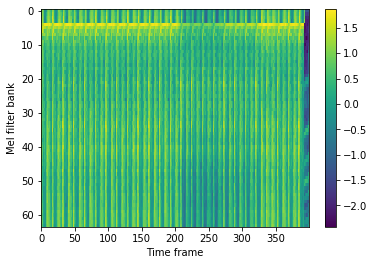

In [58]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(res.T,interpolation='nearest', aspect='auto')
plt.xlabel('Time frame')
plt.ylabel('Mel filter bank')
plt.colorbar()
plt.savefig('Audio raw')

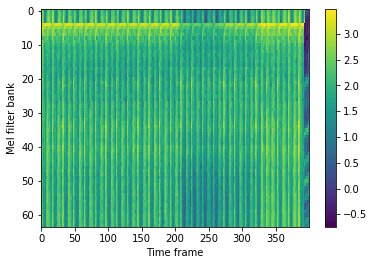

In [57]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.imshow(res.T+temp,interpolation='nearest', aspect='auto')
plt.xlabel('Time frame')
plt.ylabel('Mel filter bank')
plt.colorbar()
plt.savefig('Audio attack')

In [ ]:
torch.cuda.empty_cache()
perturb = pgd(model, pgd_dataloader, perturb, num_steps=1, step_size=0.01, step_norm=2, eps= 0.1, eps_norm=2, x_min=-10, x_max=20, y_target=None )

In [47]:
%matplotlib inline
import matplotlib.pyplot as plt
import pickle
temp = pickle.load(open('delta_global_eps_norm_2_eps_0_3_delta_force.pkl', 'rb'))
# temp[:, 20:64] =0
plt.imshow(temp.T,interpolation='nearest', aspect='auto')
plt.colorbar()

FileNotFoundError: [Errno 2] No such file or directory: 'delta_global_eps_norm_2_eps_0_3_delta_force.pkl'

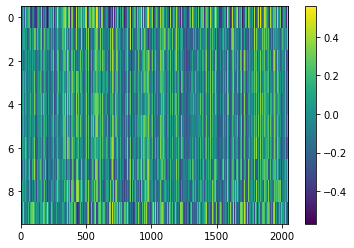

In [132]:
%matplotlib inline
import matplotlib.pyplot as plt
perturbation = perturb.detach().cpu()
perturbation = perturbation.numpy()
plt.imshow(perturbation,interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
torch.cuda.empty_cache()

In [137]:
import pickle
pickle.dump(perturb, open('delta_video_trial.pkl','wb'))

In [194]:
# get middle hidden layer

In [ ]:
def pgd(model, x, y, num_steps, step_size, step_norm, eps, eps_norm, x_min, x_max, y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    model.eval()
    x,y = torch.from_numpy(x).cuda(), torch.from_numpy(y).cuda()
    x_adv = x.clone().detach().requires_grad_(True)#.to(x.device)
    N, T, V = x.shape
    print('NTV:', N, T, V)
    targeted = y_target is not None
    num_channels = x.shape[1]
    criterion = nn.BCELoss()    
    
    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)
#         x_adv = torch.zeros((400,64)).detach().requires_grad_(True)
        out = model(_x_adv)[0] # N x T x 1
        print(out.shape)
        loss = criterion(out, y)
        print(f'loss:{loss}')
        #prediction = model(_x_adv)
        #loss = criterion(prediction, y_target if targeted else y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            if step_norm == 'inf':
                gradients = _x_adv.grad.sign() * step_size
            else:
                # The grad is normalized here.
                #gradients = _x_adv.grad 
                # Only normalize w.r.t. to feats at a timestep
                gradients = _x_adv.grad/_x_adv.grad.norm(step_norm, dim=-1).view(-1, T, 1)
                gradients *= step_size
#                 print(f'gradients shape:{gradients.shape}')
            if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
                x_adv -= gradients
            else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
#                 print(f'gradient:{gradients[0]}')
#                 print(f'gradient:{gradients[1]}')
                x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x
#             print(f'deltashape:{delta.shape}')

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
# #             mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps
#             mask = torch.max(delta.view(delta.shape[0], -1).norm(eps_norm, dim=1), dim=0, keepdim=True) <= eps #1 400 64
#             mask, ind = torch.max(delta.view(delta.shape[0], -1).norm(eps_norm, dim=1), dim=0, keepdim=True) #1 400 64
#             print(f'mask shape1:{mask.shape}')
# #             mask = mask.repeat(mask, N, 1)
# #             print(f'mask shape2:{mask.shape}')
#             # 100 400 64
#             scaling_factor = delta.view(delta.shape[0], T, -1).norm(eps_norm, dim=-1)
#             scaling_factor[mask] = eps
            
#             
            
            mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps #100*(25600) => 100
#             print(f'mask shape: {mask.shape}')
            scaling_factor = delta.view(delta.shape[0], T, -1).norm(eps_norm, dim=-1)
            #100 400 64 => 100 400
#             print(f'scaling shape: {scaling_factor.shape}')
#             print(mask)
            scaling_factor[mask] = eps
#             print(scaling_factor)
            #print(scaling_factor.shape)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, T, 1)
            delta = torch.mean(delta,0)
            x_adv = x + delta
#             print(f'delta:{delta.shape}')
            # x_adv = x + torch.audio.MelSpec(delta)
        x_adv = x_adv.clamp(x_min, x_max)

    return x_adv.detach()

In [ ]:
perturb = pgd(model, gas_eval_x, gas_eval_y, num_steps=1000, step_size=0.01, step_norm=2, eps= 0.1, eps_norm=2, x_min=-10, x_max=20, y_target=None )

In [ ]:
print(perturbation)

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
perturbation = perturb[0].detach().cpu() - x[0]
perturbation = perturbation.numpy()
perturbation[perturbation< np.max(perturbation)-0.05] = 0
plt.imshow(perturbation,interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
print(hash_val[0])
result = model(perturb)
print(torch.argmax(result[0]))



In [ ]:
result_origin = model(torch.from_numpy(x[0:1]).cuda())
print(result_origin[0].shape)
print(torch.argmax(result_origin[0]))

In [ ]:
print(np.argmax(y[0]))

In [ ]:
%matplotlib inline
import matplotlib.pyplot as plt
perturbation = (x[0])
plt.imshow(perturbation.T,interpolation='nearest', aspect='auto')
plt.colorbar()

In [ ]:
for batch in range(1, args.ckpt_size + 1):
        x, y = next(train_gen)
        global_prob = model(x)[0]
        global_prob.clamp_(min = 1e-7, max = 1 - 1e-7)
        loss = criterion(global_prob, y)
        if args.gradient_accumulation > 1:
            loss = loss / args.gradient_accumulation
        #if n_gpu > 1:
        #    loss = loss.mean()
        train_loss += loss.item()
        if numpy.isnan(train_loss) or numpy.isinf(train_loss): break
        loss.backward()
        global_step += 1
        if global_step % args.gradient_accumulation == 0:
            optimizer.step()
            if args.scheduler == 'warmup-decay':
                scheduler.step() 
            optimizer.zero_grad()
        if batch % 500 == 0:
            sys.stderr.write('Checkpoint %d, Batch %d / %d, avg train loss = %f\r' % \
                            (checkpoint, batch, args.ckpt_size, train_loss / batch))
            tb_writer.add_scalar('lr', optimizer.param_groups[0]['lr'], global_step)
            tb_writer.add_scalar('loss', train_loss / batch, global_step)
            
        del x, y, global_prob, loss         # This line and next line: to save GPU memory
        torch.cuda.empty_cache()            # I don't know if they're useful or not
    train_loss /= args.ckpt_size


In [ ]:
def train(opt, model, adv_jam, trainloader, max_batches = 100):
    model.eval()
        
    batches = 0
    total = 0
    error = 0
    loss_ = 0.
    torch.manual_seed(0)

    for X_batch, y_batch in trainloader:
        # forward pass
        X_batch, y_batch = X_batch.cuda(), y_batch.cuda()
        # plot(X_batch[0], y_batch[0])
        output = model(adv_jam(X))
        opt.zero_grad()
        neg_loss = -nn.CrossEntropyLoss()(output, y)

        neg_loss.backward()
        opt.step()



        # Evaluate performance
        adv_out = model(X_adv)
        adv_prediction = sigmoid(adv_out.squeeze().cpu().detach())>0.5
        adv_accuracy = (adv_prediction.numpy()==y_batch.cpu().numpy()).mean()
        print("Accuracy = {0}".format(adv_accuracy))
                # project into feasible region
        adv.jam.param1.clamp_(0,1)
        adv.jam.param2.clamp_(1, 40)
        adv.jam.param3.clamp_(0,224)
        total += X.shape[0]
        error += (output.max(1)[1] != y).sum().item()
        loss_ += nn.CrossEntropyLoss(size_average=False)(output, y).item()
            batches += 1
            if batches > max_batches:
                break

        return error / total, loss_ / total

In [ ]:
def projected_gradient_descent(model, x, y, num_steps = 20, step_size = 0.1, step_norm=2, eps = 10, eps_norm=2,
                               clamp=(x_min, x_max), y_target=None):
    """Performs the projected gradient descent attack on a batch of images."""
    x_adv = x.clone().detach().requires_grad_(True)#.to(x.device)
    N, T, V = x.shape
    targeted = y_target is not None
    num_channels = x.shape[1]
    criterion = nn.BCELoss()

    for i in range(num_steps):
        _x_adv = x_adv.clone().detach().requires_grad_(True)
        
        out = model(_x_adv) # N x T x 1
        out_flatten = out.reshape(-1) 
        y_flatten = y.reshape(-1)
        loss = criterion(out_flatten, y_flatten)
        
        #prediction = model(_x_adv)
        #loss = criterion(prediction, y_target if targeted else y)
        loss.backward()

        with torch.no_grad():
            # Force the gradient step to be a fixed size in a certain norm
            if step_norm == 'inf':
                gradients = _x_adv.grad.sign() * step_size
            else:
                # The grad is normalized here.
                #gradients = _x_adv.grad 
                # Only normalize w.r.t. to feats at a timestep
                gradients = _x_adv.grad/_x_adv.grad.norm(step_norm, dim=-1).view(-1, T, 1)
                gradients *= step_size
                
            if targeted:
                # Targeted: Gradient descent with on the loss of the (incorrect) target label
                # w.r.t. the image data
                x_adv -= gradients
            else:
                # Untargeted: Gradient ascent on the loss of the correct label w.r.t.
                # the model parameters
                x_adv += gradients

        # Project back into l_norm ball and correct range
        if eps_norm == 'inf':
            # Workaround as PyTorch doesn't have elementwise clip
            x_adv = torch.max(torch.min(x_adv, x + eps), x - eps)
        else:
            delta = x_adv - x

            # Assume x and x_adv are batched tensors where the first dimension is
            # a batch dimension
            mask = delta.view(delta.shape[0], -1).norm(eps_norm, dim=1) <= eps

            scaling_factor = delta.view(delta.shape[0], T, -1).norm(eps_norm, dim=-1)
            scaling_factor[mask] = eps
            #print(scaling_factor.shape)
            # .view() assumes batched images as a 4D Tensor
            delta *= eps / scaling_factor.view(-1, T, 1)

            x_adv = x + delta
            
        x_adv = x_adv.clamp(*clamp)

    return x_adv.detach()